# Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split

# Add the parent folder to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))
from src.model import GroupMedianImputer


# Load Data

In [ ]:
train_data = pd.read_csv("../data/processed/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,TicketFeature,FamSize,FamType,Title,Deck
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,OTHER,2,Small,Mr,Unknown
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,OTHER,2,Small,Mrs,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,OTHER,1,Solo,Miss,Unknown
3,4,1,1,female,35.0,1,0,113803,53.1000,S,OTHER,2,Small,Mrs,C
4,5,0,3,male,35.0,0,0,373450,8.0500,S,OTHER,1,Solo,Mr,Unknown


In [3]:
test_data = pd.read_csv("../data/processed/test.csv")
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,TicketFeature,FamSize,FamType,Title,Deck
0,892,3,male,34.5,0,0,330911,7.8292,Q,OTHER,1,Solo,Mr,Unknown
1,893,3,female,47.0,1,0,363272,7.0000,S,OTHER,2,Small,Mrs,Unknown
2,894,2,male,62.0,0,0,240276,9.6875,Q,OTHER,1,Solo,Mr,Unknown
3,895,3,male,27.0,0,0,315154,8.6625,S,OTHER,1,Solo,Mr,Unknown
4,896,3,female,22.0,1,1,3101298,12.2875,S,OTHER,3,Small,Mrs,Unknown


In [4]:
# Create copies and separate targets from features
titanic_train = train_data.copy()
titanic_train_target = titanic_train["Survived"]
titanic_train = train_data.drop("Survived", axis=1)

X_test = test_data.copy()

# Stratified Train-Test-Split

In [5]:
# Split train into train/validation
X = train_data.drop(columns=["Survived"])
y = train_data["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# Data Preprocessing Pipeline

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


# num_attr = ["Age", "Fare"]
cat_attr = ["Pclass", "Sex"]#, "Embarked", "Ticket",  "FamType", "Title", "Deck"] # PassengerId, Ticket, Cabin

# num_pipeline = make_pipeline(
#     SimpleImputer(strategy="median"),
#     StandardScaler(),
# )

age_pipeline = make_pipeline(
    # GroupMedianImputer(
    #     group_cols=["Sex", "Pclass"],#, "Title"],
    #     target_col="Age"
    # ),
    StandardScaler()
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler(),
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessing = ColumnTransformer([
    # ("age", age_pipeline, ["Age", "Sex", "Pclass", "Title"]),
    # ("log", log_pipeline, ["Fare"]),
    ("cat", cat_pipeline, cat_attr),
])

# rbf

# X = preprocessing.fit_transform(X)
# X.shape # .toarray()

### Features

In [14]:
# print("Features in: \n", preprocessing.feature_names_in_)
# print("\nFeatures out: \n", preprocessing.get_feature_names_out())

### Pipeline Visualization

In [15]:
import sklearn
sklearn.set_config(display="diagram")
preprocessing

,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


# Prediction

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Features to use
features = ["Sex", "Pclass"] # "Age", "Fare", "Pclass", "Sex", "Embarked", "Ticket", "FamType", "Title", "Deck"]

# Pipeline
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", RandomForestClassifier(random_state=42))
])

# Fit pipeline on training split
full_pipeline.fit(X_train[features], y_train)

# Validation performance
y_val_pred = full_pipeline.predict(X_val[features])
from sklearn.metrics import accuracy_score
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))


Validation Accuracy: 0.776536312849162


In [17]:
from sklearn.model_selection import StratifiedKFold

# create param grid object 
# forest_params = dict(
#     model__max_depth = [n for n in range(9, 14)],
#     model__min_samples_split = [n for n in range(4, 11)],
#     model__min_samples_leaf = [n for n in range(2, 5)],
#     model__n_estimators = [n for n in range(10, 60, 10)]
# )

# Hyperparameter grid
param_grid = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [3, 5, 7, None],
    "model__max_features": ["sqrt", "log2"],
    "model__min_samples_split": [2, 5, 10]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

forest_cv = GridSearchCV(
    full_pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring="accuracy"
)
forest_cv.fit(X_train[features], y_train)

best_model = forest_cv.best_estimator_
val_preds = best_model.predict(X_val[features])

from sklearn.metrics import accuracy_score, classification_report
print("Validation accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))


Validation accuracy: 0.776536312849162
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.74      0.65      0.69        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179



Validation accuracy: 0.8268156424581006
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179

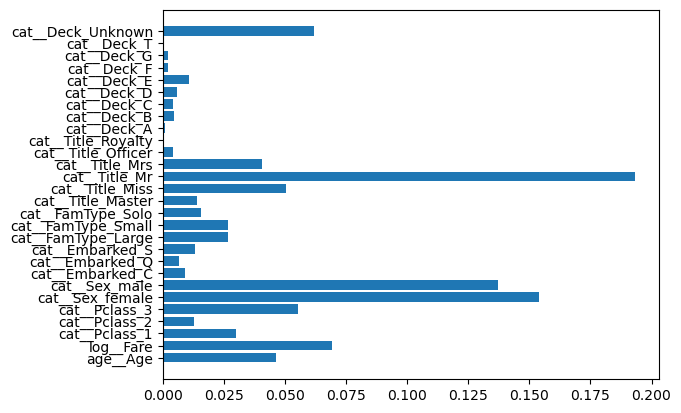

In [19]:
import matplotlib.pyplot as plt
importances = best_model.named_steps["model"].feature_importances_
feature_names = best_model.named_steps["preprocessing"].get_feature_names_out()
plt.barh(feature_names, importances)
plt.show()


In [21]:
test_preds = best_model.predict(X_test[features])
output = pd.DataFrame({
    "PassengerId": X_test.PassengerId,
    "Survived": test_preds
})

output.to_csv('../results/submission.csv', index=False)
print("Your submission was successfully saved!")
output

Your submission was successfully saved!


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Pipeline with placeholder
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", RandomForestClassifier())  # placeholder
])

param_grid = [
    {
        "model": [RandomForestClassifier(random_state=42)],
        "model__n_estimators": [100, 300],
        "model__max_depth": [3, 5, None]
    },
    {
        "model": [LogisticRegression(max_iter=500)],
        "model__C": [0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"]
    },
    {
        "model": [GradientBoostingClassifier(random_state=42)],
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1]
    }
]

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring="accuracy"
)
grid.fit(X_train[features], y_train)

print(grid.best_estimator_)
print("Best CV score:", grid.best_score_)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('groupmedianimputer',
                                                                   GroupMedianImputer(group_cols=['Sex',
                                                                                                  'Pclass',
                                                                                                  'Title'])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sex', 'Pclass',
                                                   'Title']),
                                                 ('log',
                                                  Pipeline(steps=[('simpleimputer',
                                              

# TODO: Try different features

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Features to use
features = ["Age", "Fare", "Pclass", "Sex", "Embarked", "FamType", "Title", "Deck"]

# Pipeline
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", RandomForestClassifier(random_state=1))
])

# Hyperparameter grid
param_grid = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [3, 5, 7, None],
    "model__max_features": ["sqrt", "log2"],
    "model__min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X[features], y)

print("Best score (RF):", grid_search.best_score_)
print("Best params (RF):", grid_search.best_params_)

# Predict on test set
predictions = grid_search.predict(titanic_test[features])

output = pd.DataFrame({
    "PassengerId": titanic_test.PassengerId,
    "Survived": predictions
})

output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output

## Random Forest - no preprocessing

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# y = train_data["Survived"]

# features = ["Pclass", "Sex", "SibSp", "Parch"]
# X = pd.get_dummies(train_data[features])
# X_test = pd.get_dummies(test_data[features])

# model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
# model.fit(X, y)
# predictions = model.predict(X_test)

# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# # output.to_csv('submission.csv', index=False)
# # print("Your submission was successfully saved!")
# output

 Performance on test_data: 0.77511

# Logistic Regression

In [10]:
from sklearn.pipeline import Pipeline


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Features to use
features = ["Age", "Fare", "Pclass", "Sex", "Embarked", "FamType", "Title", "Deck"]

# Full pipeline: preprocessing + logistic regression
logreg_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # your ColumnTransformer
    ("model", LogisticRegression(max_iter=1000, random_state=1))
])

param_grid = {
    "model__C": [0.01, 0.1, 1, 10],   # regularization strength
    "model__penalty": ["l2"],         # solver must match penalty
    "model__solver": ["lbfgs"]
}

grid_search = GridSearchCV(
    logreg_pipeline,
    param_grid,
    cv=5,            # 5-fold cross-validation
    scoring="accuracy"
)

grid_search.fit(X, y)

print("Best score:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

# Use best model to predict
predictions = grid_search.predict(titanic_test)

# Prepare submission
output = pd.DataFrame({
    "PassengerId": titanic_test.PassengerId,
    "Survived": predictions
})

output.to_csv("submission.csv", index=False)
output.head()

In [ ]:
from sklearn.linear_model import LogisticRegression

# Features to use
features = ["Age", "Fare", "Pclass", "Sex", "Embarked", "FamType", "Title", "Deck"]

# Full pipeline: preprocessing + logistic regression
logreg_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # your ColumnTransformer
    ("model", LogisticRegression(max_iter=1000, random_state=1))
])

# Fit pipeline
logreg_pipeline.fit(X[features], y)

# Predict on test data
predictions = logreg_pipeline.predict(titanic_test[features])

# Prepare submission
output = pd.DataFrame({
    "PassengerId": titanic_test.PassengerId,
    "Survived": predictions
})

# output.to_csv("submission.csv", index=False)
output.head()


In [ ]:
# Get model and preprocessing
logreg = logreg_pipeline.named_steps["model"]
preprocessor = logreg_pipeline.named_steps["preprocessing"]

# Feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Build a DataFrame
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": logreg.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df#.head()


In [ ]:
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df

In [ ]:
import matplotlib.pyplot as plt
coef_df.sort_values("coefficient", inplace=True)
plt.figure(figsize=(8,10))
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.xlabel("Log-odds coefficient")
plt.title("Logistic Regression Feature Coefficients")
plt.show()


In [ ]:
# Access the categorical pipeline
cat_pipeline_inside = preprocessing.named_transformers_["cat"]

# Check the step names
print(cat_pipeline_inside.named_steps)


# Get the first OneHotEncoder in the pipeline automatically
ohe = [step for step in cat_pipeline_inside.named_steps.values()
       if isinstance(step, OneHotEncoder)][0]
cat_feature_names = ohe.get_feature_names_out(cat_attr)


In [ ]:
ohe = cat_pipeline_inside.named_steps["onehotencoder"]

# Get categorical feature names
cat_feature_names = ohe.get_feature_names_out(cat_attr)
cat_feature_names

In [ ]:
all_feature_names = ["Age", "Fare"] + list(cat_feature_names)
all_feature_names

# Decision Tree

# Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Features to use
features = ["Age", "Fare", "Pclass", "Sex", "Embarked", "FamType", "Title", "Deck"]

# Pipeline
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", RandomForestClassifier(random_state=1))
])


# create param grid object 
forest_params = dict(
    model__max_depth = [n for n in range(9, 14)],
    model__min_samples_split = [n for n in range(4, 11)],
    model__min_samples_leaf = [n for n in range(2, 5)],
    model__n_estimators = [n for n in range(10, 60, 10)]
)


# instantiate Random Forest model
# forest = RandomForestClassifier()

# build and fit model 
forest_cv = GridSearchCV(full_pipeline, param_grid=forest_params, cv=5) 
forest_cv.fit(X[features], y)

print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

In [ ]:
# Predict on test set
predictions = forest_cv.predict(titanic_test[features])

output = pd.DataFrame({
    "PassengerId": titanic_test.PassengerId,
    "Survived": predictions
})

output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Features to use
features = ["Age", "Fare", "Pclass", "Sex", "Embarked", "FamType", "Title", "Deck"]

# Pipeline
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", RandomForestClassifier(random_state=1))
])

# Hyperparameter grid
param_grid = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [3, 5, 7, None],
    "model__max_features": ["sqrt", "log2"],
    "model__min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X[features], y)

print("Best score (RF):", grid_search.best_score_)
print("Best params (RF):", grid_search.best_params_)

# Predict on test set
predictions = grid_search.predict(titanic_test[features])

output = pd.DataFrame({
    "PassengerId": titanic_test.PassengerId,
    "Survived": predictions
})

output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Target
y = train_data["Survived"]

# Features to use
features = ["Age", "Fare", "Pclass", "Sex", "Embarked", "FamType", "Title", "Deck"]

# Create a full pipeline: preprocessing + model
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),   # your ColumnTransformer from before
    ("model", RandomForestClassifier(n_estimators=500, max_depth=5, random_state=1))
])

# Fit the pipeline on training data
full_pipeline.fit(titanic_train[features], y)

# Predict on test data
predictions = full_pipeline.predict(titanic_test[features])

# Prepare submission
output = pd.DataFrame({
    'PassengerId': test_data.PassengerId,
    'Survived': predictions
})

# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")
output


 Performance on test_data: 0.77990

In [ ]:
# 1. Get trained RF model
rf = full_pipeline.named_steps["model"]

# 2. Get feature names from preprocessing
preprocessor = full_pipeline.named_steps["preprocessing"]

feature_names = preprocessor.get_feature_names_out()

# 3. Build importance DataFrame
importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

importances.head(20)


In [ ]:
from sklearn.inspection import permutation_importance

X_val = titanic_train[features]
y_val = y

result = permutation_importance(
    full_pipeline,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importances = pd.DataFrame({
    "feature": features,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values(by="importance_mean", ascending=False)

perm_importances


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = importances.sort_values(by="importance", ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_imp, palette="viridis")
plt.title("Random Forest Feature Importances (one-hot expanded)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Target
y = titanic_train_target # train_data["Survived"]

# Features to use
features = ["Age", "Fare", "Pclass", "Sex", "Embarked", "FamType", "Title", "Deck"]

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        random_state=1
    ))
])

# Fit the pipeline on training data
full_pipeline.fit(titanic_train[features], y)

# Predict on test data
predictions = full_pipeline.predict(titanic_test[features])

# Prepare submission
output = pd.DataFrame({
    'PassengerId': test_data.PassengerId,
    'Survived': predictions
})

output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output


# Support Vector Machine